Following example here: https://examples.ionsim.org/tutorial-notebooks/getting_started.html

In [1]:
# # ############ Most important package specs ############

# using Pkg
# Pkg.add(Pkg.PackageSpec(;name="IonSim", version="0.5.1"))
# Pkg.add(Pkg.PackageSpec(;name="QuantumOptics", version="1.0.15"))

# # ############ Other package specs ############

# Pkg.add("Revise")
# Pkg.add("PyPlot")
# Pkg.add("StochasticDiffEq")
# Pkg.add("DSP")

In [6]:
# ############ To set default Python environment ############

# using Pkg

# Pkg.add("PyCall")

# #ENV["PYTHON"] = raw"C:\Users\abdel\anaconda3\envs\ion_sim\python.exe" # If Julia on Windows
# ENV["PYTHON"] = raw"/mnt/c/Users/abdel/anaconda/envs/ion_sim/python.exe" # If Julia on WSL

# Pkg.build("PyCall")

# using PyCall
# print(PyCall.python)

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/51cab8e982c5b598eea9c8ceaced4b58d9dd37c9/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


/home/aelabd/.julia/conda/3/x86_64/bin/python

In [7]:
using Revise
using IonSim
using QuantumOptics: timeevolution, stochastic, Basis

import PyPlot
const plt = PyPlot;

## Begin: IonSim handling

### Define the ion

In [8]:
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])

print("ca: ", ca)
print("\n\nca is of type Ion: ", typeof(ca) <: Ion)
print("\n\nsublevelaliases(ca): ")
for i in sublevelaliases(ca)
    print("\n", i[1], ": ", i[2])
end


ca: ⁴⁰Ca

ca is of type Ion: true

sublevelaliases(ca): 
S: ("S1/2", -1//2)
D: ("D5/2", -1//2)

### Define the laser

In [9]:
laser = Laser()
print(laser)

λ: missing m
Δ: 0 Hz
̂ϵ: (x=0.7071067811865475, y=0.7071067811865475, z=0.0)
k̂: (x=0, y=0, z=1)
I(t=0): 0 W/m²
ϕ(t=0): 0.0 ⋅ 2π


### Define the ion-chain

Warning: The cell below is completely and utterly non-deterministic. 

Sometimes the cell below doesn't terminate, no matter what you do. It may have to do with the cell above initiating some backend Julia stuff. Make sure that the Julia-log (i.e. the very bottom of the VSCode window, where it usually says 'Julia env: v1.10' if no backend stuff is going on) is stable (i.e. it just says 'Julia env: v1.10')

In [10]:
chain = LinearChain(
        ions=[ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), # <-- what are the comm frequencies? 
        selectedmodes=(;z=[1])
    )

print("chain is of type IonTrap: ", typeof(chain) <: IonTrap)
print("\n\nchain modes: ", modes(chain))

# Hint: If cell is stuck, press Alt+J then Alt+K
#   Or Alt+J then click the square button that interrupts the kernel

chain is of type IonTrap: true

chain modes: VibrationalMode[VibrationalMode(ν=1.0e6, axis=ẑ, N=10)]

### Define the chamber

In [11]:
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser]);

print("chamber is of type Chamber: ", typeof(chamber) <: Chamber)
print("\nchamber basis: ", basis(chamber))

chamber is of type Chamber: true
chamber basis: [⁴⁰Ca ⊗ VibrationalMode(ν=1.0e6, axis=ẑ, N=10)]

### Set the laser's wavelength to $\lambda = Ca^{40}_{S\to D}$ transition wavelength

In [12]:
λ = transitionwavelength(ca, ("S", "D"), chamber)
wavelength!(laser, λ)

7.291469960190796e-7

### Set the laser's wavevector to $\vec{k} = (\hat{x}+\hat{z})/\sqrt{2}$

In [13]:
wavevector!(laser, (x̂ + ẑ)/√2)

(x = 0.7071067811865475, y = 0.0, z = 0.7071067811865475)

### Set the laser's polarization to $\vec{\epsilon} = (\hat{x}-\hat{z})/\sqrt{2}$

In [14]:
polarization!(laser, (x̂ - ẑ)/√2)

(x = 0.7071067811865475, y = 0.0, z = -0.7071067811865475)

### Set the laser's intensity to I = necessary intensity for $Ca^{40}_{S\to D}$ transition within 2 $\mu$ s 

Q: So are we determining the Rabi frequency by doing this?

In [15]:
intensity_from_pitime!(laser, 2e-6, ca, ("S", "D"), chamber);  # Sets pi_time to 2 μs

### Set the laser's phase at $t=0$ to $\varphi = 0$

In [16]:
phase!(laser,0)

#35 (generic function with 1 method)

### Still haven't set laser.$\Delta$, laser.pointing

I think laser.$\Delta$ is the detuning.

Also, do they mean laser.poynting?

In [17]:
propertynames(laser)

(:λ, :I, :Δ, :ϵ, :k, :ϕ, :pointing)

### Construct the Hamiltonian, given all these parameters

This is not a Hamiltonian matrix, since the laser - and therefore the Hamiltonian - are time-dependent. Instead this is a function which returns the Hamiltonian matrix at a given time $t$. 

In [18]:
h = hamiltonian(chamber, timescale=1e-6);

# 

(::IonSim.var"#f#150"{QuantumOpticsBase.Operator{QuantumInterface.CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, VibrationalMode}}, QuantumInterface.CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, VibrationalMode}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, Vector{FunctionWrappers.FunctionWrapper}, Vector{Vector{Vector{Int64}}}, FunctionWrappers.FunctionWrapper{Float64, Tuple{Float64}}, Vector{Float64}, Vector{Vector{Int64}}, Vector{Int64}, Vector{Vector{Tuple{Int64, Int64}}}, Vector{Vector{Tuple{Int64, Int64}}}, Vector{FunctionWrappers.FunctionWrapper}}) (generic function with 1 method)

### Define the initial state

The ion

In [19]:
ion = ions(chamber)[1]
print(ion)

⁴⁰Ca
("S1/2", -1//2): "S"
("D5/2", -1//2): "D"


The $S1/2 \sim \ket{0}$ state of the ion

In [20]:
ψ0_ion = ion["S"]
# ψ0_ion = ion[("S1/2", -1/2)]
# ψ0_ion = ionstate(ion, "S")

print(ψ0_ion)

Ket(dim=2)
  basis: ⁴⁰Ca
 1.0 + 0.0im
 0.0 + 0.0im

The vibration modes

In [21]:
chamber_modes = modes(chamber)
print(chamber_modes)

VibrationalMode[VibrationalMode(ν=1.0e6, axis=ẑ, N=10)]

The first vibrational mode

In [22]:
first_mode = chamber_modes[1]
print(first_mode)

VibrationalMode(ν=1.0e6, axis=ẑ, N=10)

The fock state corresponding to n=1 in the first index and n=0 elsewhere

In [23]:
ψ0_mode = first_mode[0]
# ψ0_mode = fockstate(mode, 0)
# ψ0_mode = groundstate(mode)

print(ψ0_mode)

Ket(dim=11)
  basis: VibrationalMode(ν=1.0e6, axis=ẑ, N=10)
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

The state: $Ca^{40}_{S1/2} \otimes \ket{0}$

In [24]:
ψ0 = ψ0_ion ⊗ ψ0_mode

Ket(dim=22)
  basis: [⁴⁰Ca ⊗ VibrationalMode(ν=1.0e6, axis=ẑ, N=10)]
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

## Begin: QuantumOptics handling

### Solve Schrodinger equation for time-evolution of $\psi$

In [25]:
# Integration time
T = [0:0.1:20;]
@time tout, ψt = timeevolution.schroedinger_dynamic(T, ψ0, h);

  3.268401 seconds (12.33 M allocations: 814.655 MiB, 6.16% gc time, 99.88% compilation time)


### Plot the (expectation of) state-excitation as a function of time

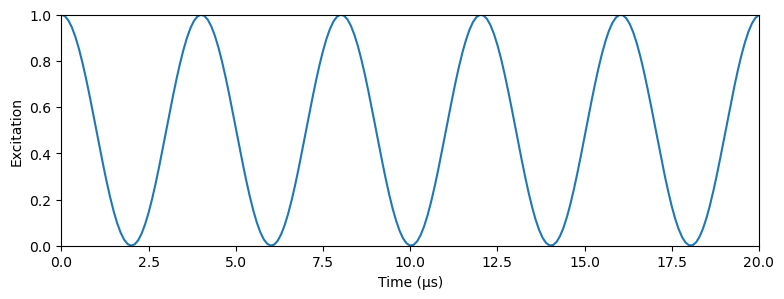

In [26]:
ex = real(expect(ionprojector(chamber, "S"), ψt))

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

In the above plot, we see Rabi oscillations with a pi-time of 2 μs, as expected.

Now if we add a detuning to the laser equal to the Rabi frequency, we should see oscillation with half the amplitude and √2 times the frequency:

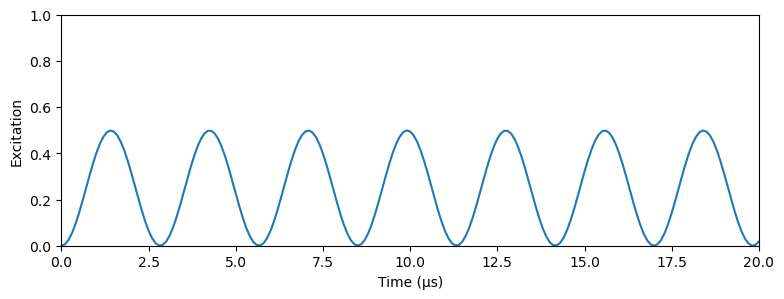

  0.005037 seconds (156.32 k allocations: 4.207 MiB)


/home/abdel/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/abdel/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [22]:
detuning!(laser, 2.5e5)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(T, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

We can achieve the same effect by instead setting a nonzero value in our ion’s manualshift field. This can be useful when we have several ions in our chain and want to simulate some energy shift, for example an AC Stark shift, without involving an additional laser resource.

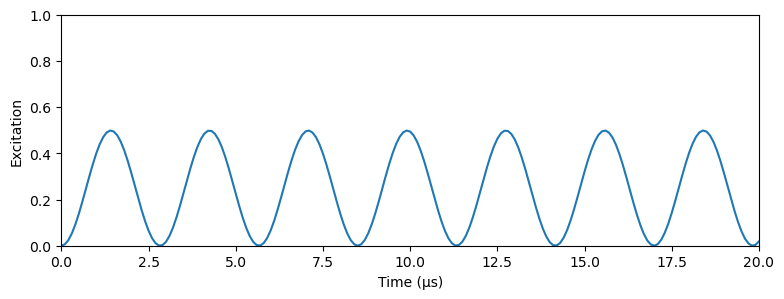

  0.005791 seconds (183.66 k allocations: 4.922 MiB)


In [23]:
detuning!(laser, 9)

manualshift!(ca, "S", -1.25e5)
manualshift!(ca, "D", 1.25e5)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(T, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

So far our simulations have used an initial state ionstate(ca, "S") ⊗ fockstate(mode, 0), or 
$\ket{S, n=0}$, but we can also start off with the vibrational mode in a thermal state.

Let’s start by increasing the dimensionality of the VibrationalMode by changing the maximum $N$ from 10 to 100.

In [24]:
modecutoff(mode)

UndefVarError: UndefVarError: `mode` not defined

In [25]:
modecutoff!(mode, 100)
modecutoff(mode)

UndefVarError: UndefVarError: `mode` not defined

In [26]:
# reset all manual shifts to zero
zeromanualshift!(ca)

# create initial state in terms of denisty matrices
ψi_ion = dm(ca["S"]) 
ψi_mode = thermalstate(mode, 10)
ψi = ψi_ion ⊗ ψi_mode

tspan = 0:0.1:50
h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=Inf, time_dependent_eta=false, displacement="truncated")
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

UndefVarError: UndefVarError: `mode` not defined

In [27]:
ex = expect(ionprojector(chamber, "D"), sol)
η = lambdicke(mode, ca, laser)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex, label="numerical")
plt.plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

UndefVarError: UndefVarError: `mode` not defined

We see good, but not perfect agreement between the two curves. In fact, the majority of this discrepancy comes from off-resonant interaction with the first order sideband which the simulation captures but the analytical solution does not.

This can be confirmed by eliminating this off-resonant interaction in our simulation by setting they keyword argument $\texttt{lamb\_dicke\_order}$ in the $\texttt{hamiltonian}$ function to zero (by default, this is set to 1).

In [28]:
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=0)  # set lamb_dicke_order here
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

UndefVarError: UndefVarError: `tspan` not defined

In [29]:
ex = expect(ionprojector(chamber, "D"), sol)
η = lambdicke(mode, ca, laser)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex, label="numerical")
plt.plot(
        tout, analytical.rabiflop(tout, 1/4, η, 10), 
        linestyle="--", label="analytical"
    )
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

UndefVarError: UndefVarError: `mode` not defined

Which gives a much better agreement between the two curves.

At this point, it’s worth explaining in more detail what we’ve just done. Conventionally, we would probably guess that setting the $\texttt{lamb\_dicke\_order}$ to $n$ would be equivalent to truncating the Taylor series expansion of the displacement operator $D(i\eta^{i\nu t})$ after the order in $\eta$.

But this is not what IonSim does. Instead, it just drops all (Fock basis) matrix elements of $\bra{m} D \ket{n}$ where 
$|m-n| > n$.

All matrix elements of the operator are computed analytically. So, for example, even if we set $\texttt{lamb\_dicke\_order=0}$, we’ll still retain the precise effect that the mode coupling has on the carrier transition – as in the above example.

## Sideband transitions

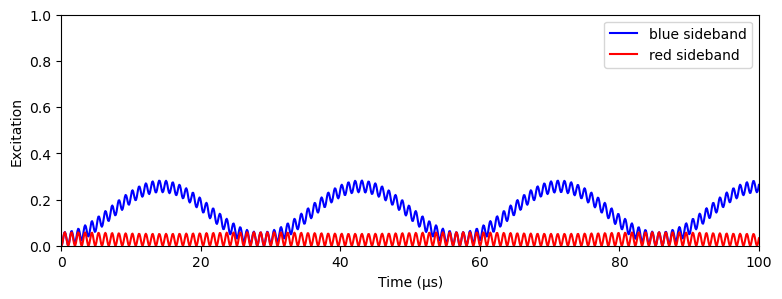

  0.039536 seconds (1.14 M allocations: 30.212 MiB)
  0.042703 seconds (1.23 M allocations: 32.727 MiB)


In [67]:
tspan = 0:0.1:100
# set the motional dimension back to 10
modecutoff!(mode, 10)

# tune laser frequency to blue sideband
ν = frequency(mode)
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

The fast oscillations come from off-resonant excitation of the carrier transition. The slower oscillations are from population being driven back and forth between $\ket{S, n=0} \leftrightarrow \ket{D, n=1}$. We only see these when detuning blue, because we start with the vibrational mode in the ground state ($\texttt{mode[0]}$).

If we instead start out in $\texttt{mode[1]}$:

  0.047755 seconds (1.31 M allocations: 34.803 MiB)
  0.044584 seconds (1.27 M allocations: 33.834 MiB)


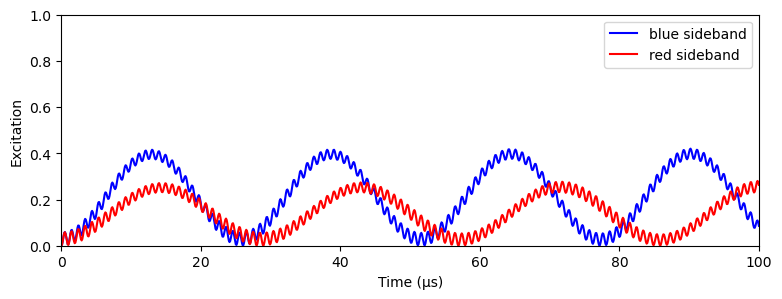

In [68]:
ψ1 = ca["S"] ⊗ mode[1]

# tune laser frequency to blue sideband
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

The large detuning is coming almost entirely from an AC Stark shift off of the carrier transition.

We can confirm this by using they $\texttt{rwa\_cutoff}$ keyword in the hamiltonian function. Setting $\texttt{rwa\_cutoff=x}$, will neglect all terms in the Hamiltonian that oscillate faster than $\texttt{x}$.
    

Since the vibrational mode frequency has been set to 1 MHz, if we set $\texttt{rwa\_cutoff=1e5}$, we should neglect the carrier Stark shift in our simulation:

  0.001019 seconds (16.67 k allocations: 948.688 KiB)
  0.000827 seconds (13.31 k allocations: 858.688 KiB)


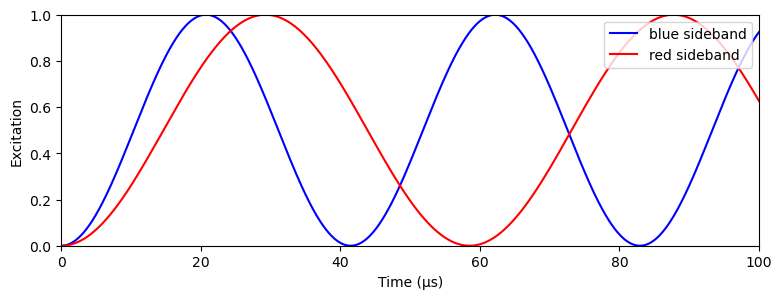

In [69]:
# tune laser frequency to blue sideband
detuning!(laser, ν)

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_blue = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

# tune laser frequency to red sideband
detuning!(laser, -ν)

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=1e-5) # set rwa_cutoff here
@time tout, sol_red = timeevolution.schroedinger_dynamic(tspan, ψ1, h)

ex_blue = expect(ionprojector(chamber, "D"), sol_blue)
ex_red = expect(ionprojector(chamber, "D"), sol_red)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex_blue, color="blue", label="blue sideband")
plt.plot(tout, ex_red, color="red", label="red sideband")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

A final note about the $\texttt{rwa\_cutoff}$: If $\texttt{hamiltonian}$ knows that you’re not performing an RWA, it can do some optimization to reduce the number of internal functions that need to be evaluated, leading to faster performance. We can let it know that we’re not performing an RWA by setting $\texttt{rwa\_cutoff=Inf}$ (this is the default value).

To reiterate: if you’re not performing an RWA, then setting $\texttt{rwa\_cutoff}$ equal to $\texttt{Inf}$, rather than some arbitrarily large value, will lead to faster performance.

## Time-dependent parameters

All of the parameters denoted as time-dependent in the Hamiltonian equation at the start of this notebook can be set to arbitrary single-valued functions by the user. This can be useful for things like optimal control and modeling noise.

Below we’ll give a couple of examples of this.

First we note that the Stark shift-induced detuning of the BSB Rabi flop in the previous section can be compensated by adding an additional detuning to the laser:

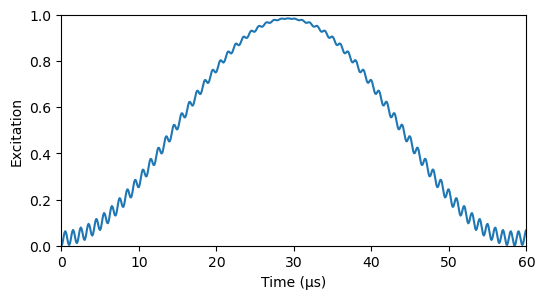

  0.026327 seconds (745.42 k allocations: 19.791 MiB)


In [72]:
# add additional detuning to BSB to compensate for carrier Stark shift
detuning!(laser, ν-31e3)

tspan = 0:0.1:60
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
fig = plt.figure(figsize=(6,3))
plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

However, we’re still stuck with the off-resonant population oscillations from the carrier transition. It turns out we can eliminate these by ramping up the amplitude of the laser at the beginning of the simulation.

Such a ramp can be set with the $\texttt{intensity}$ of the laser:

In [73]:
# get previous value of intensity field strength
I = intensity_from_pitime(1, 2e-6, 1, ("S", "D"), chamber) 

# Simple amplitude ramping function
function Ω_4us(t)
    if t < 4
        return sin(2π * t / 16)^2
    else
        return 1
    end
end

intensity!(laser, t -> I*Ω_4us(t)^2);

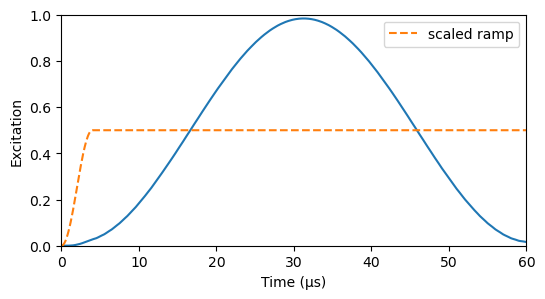

  0.062765 seconds (1.38 M allocations: 32.732 MiB, 6.94% compilation time)


In [74]:
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)

fig = plt.figure(figsize=(6,3))
plt.plot(tout, ex)
plt.plot(tout, @.(Ω_4us(tout)/2), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

To be a bit more succinct we can use a *Julia anonymous function*:

In [75]:
# To make things interesting let's also reduce the ramp time from 4 μs to 1 μs
Ω_1us = t -> t < 1 ? sin(2π * t / 4)^2 : 1
intensity!(laser, t -> I*Ω_1us(t)^2);

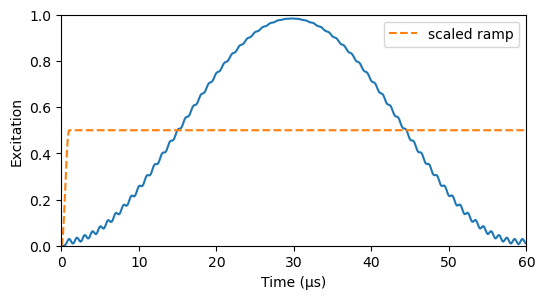

  0.072972 seconds (1.50 M allocations: 34.785 MiB, 12.41% compilation time)


In [76]:
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)

fig = plt.figure(figsize=(6,3))
plt.plot(tout, ex)
plt.plot(tout, @.(Ω_1us(tout)/2), linestyle="--", label="scaled ramp")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

Even with just a 1 μs ramp, we already see noticeable reduction of the fast oscillations.

As an applied example of a time-dependent laser frequency, we can simulate Rapid Adiabatic Passage or RAP [WHK+07], which can be used for robust preparation of the ion in an excited state.

We’ll linearly sweep through the laser’s frequency from -150 kHz to +150 kHz detuned from the carrier transition in a time $\texttt{Tp}$

In [77]:
# the length of time of the frequency chirp in μs
Tp = 150

# Δϕ is equal to half the detuning range we will chirp the laser over multiplied by the timescale (1e-6)
Δϕ = 2π * 150e-3

# Set the frequency chirp
phase!(laser, t -> (-Δϕ + (2Δϕ / Tp) * t) * t);

We’ll also ramp the Rabi frequency:

In [86]:
I = intensity_from_pitime(1, 6.5e-6, 1, ("S", "D"), chamber)
tr = 33
function Ω(t)
    if t < tr
        return sin(2π * t / 4tr)^2
    elseif tr <= t <= 150 - tr
        return 1
    elseif 150 - tr < t < 150
        return sin(2π * (t - 150) / 4tr)^2
    else
        return 0
    end
end

intensity!(laser, t -> I*Ω(t)^2);

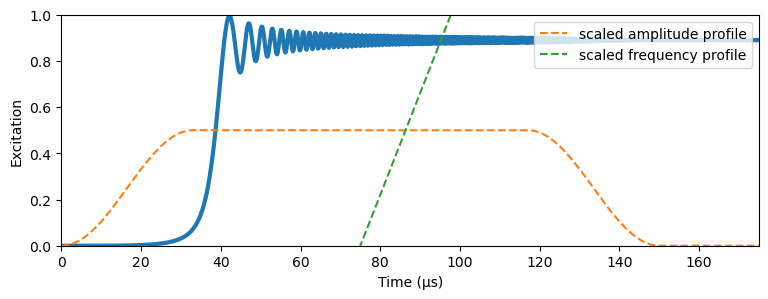

  0.166950 seconds (5.46 M allocations: 109.659 MiB, 7.27% gc time)


In [87]:
# Set the B-field to match the value in the reference
bfield!(chamber, 2.9e-4)

# set detuning back to carrier at new magnetic field
wavelength_from_transition!(laser, ca, ("S", "D"), chamber);
detuning!(laser, 0)

tspan = 0:0.1:175
h = hamiltonian(chamber, timescale=1e-6)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)

ex = expect(ionprojector(chamber, "D"), sol)
ϕ = phase(laser)

fig = plt.figure(figsize=(9,3))
plt.plot(tout, ex, lw=3)
plt.plot(
        tout, @.(Ω(tout)/2), 
        linestyle="--", label="scaled amplitude profile"
    )
plt.plot(
        tout, @.(ϕ(tout) / (2Δϕ * tout)), 
        linestyle="--", label="scaled frequency profile"
    )
plt.xlim(tout[1], tout[end])
plt.legend(loc=1)
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.display(fig)

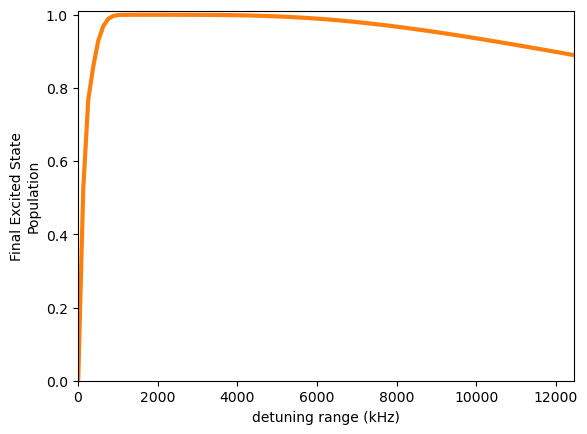

In [88]:
detuning_range = 2π*1e-6 .* collect(1e3:2e4:2e6)
pops = Vector{Float64}(undef, 0)
for Δϕ in detuning_range
    phase!(laser, t -> (-Δϕ/2 + (Δϕ / Tp) * t) * t)
    h = hamiltonian(chamber, timescale=1e-6)
    _, sol = timeevolution.schroedinger_dynamic(tspan, ψ0, h)
    push!(pops, real(expect(ionprojector(chamber, "D"), sol)[end]))
end

fig = plt.figure()
plt.plot(@.(detuning_range * 1e3), pops, lw=3, color="C1")
plt.xlim(-10, detuning_range[end] * 1e3)
plt.ylim(0, 1.01)
plt.ylabel("Final Excited State\nPopulation")
plt.xlabel("detuning range (kHz)");
plt.display(fig)

## Noise (in progress)

QuantumOptics has several solvers that can incorporate noise. Here are some examples for using these with IonSim.

First we’ll consider decoherence of the state $\ket{\psi} = \ket{S} + \ket{D}$ due to B-field fluctuations, which can be implemented by setting T.δB which has units of Tesla (we won’t do it here, but this value can also be made time-dependent).

In [89]:
# using StochasticDiffEq

In [90]:
# tspan = collect(0:10.:30000)
# β = 1e-2
# σ = √(2β)
# w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
# w.dt = 0.1;

In [91]:
# plt.title("O-U noise")
# warray = [w(t)[1] for t in tspan]
# plt.plot(tspan, warray)
# plt.show()

In [92]:
# using DSP: periodogram

In [93]:
# sample_rate = (length(tspan) - 1)/tspan[end]
# pwarray = periodogram(warray, fs=sample_rate)
# freqs = pwarray.freq
# abs_freqs = freqs .* 1e6
# powers = pwarray.power
# N = 50
# for i in 1:N-1
#     w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
#     w.dt = 0.1
#     warray = [w(t)[1] for t in tspan]
#     powers .+= periodogram(warray, fs=sample_rate).power
# end
# powers ./= powers[2]

# plt.loglog(abs_freqs, powers, label="numerical")
# ou_psd(f) = σ^2 / (β^2 + (2π * f)^2)
# plt.loglog(abs_freqs, ou_psd.(freqs) ./ ou_psd(freqs[2]), color="C1", label="theoretical", ls="--")
# plt.ylabel("relative power")
# plt.xlabel("frequency [Hz]")
# plt.title("O-U PSD")
# plt.ylim(10e-3, 2)
# plt.xlim(250, 2e4)
# plt.legend()
# plt.show()

In [94]:
# # Let's create a new Ion with the right energy sublevels for a Δm = 2 transition
# C = Ca40([("S1/2", -1/2), ("D5/2", -5/2)])
# set_sublevel_alias!(C, Dict("S" => ("S1/2", -1/2),
#                             "D" => ("D5/2", -5/2)))

# # Create a new Trap with the new Ion
# chain = LinearChain(
#         ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
#         vibrational_modes=(;z=[1]))

# T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

# # Redefine mode for new trap
# mode = T.configuration.vibrational_modes.z[1];

# # Display sublevels of new ion
# sublevels(T.configuration.ions[1])

In [95]:
# # we're not paying attention to the vibrational mode here, so we set its dimension to 1,
# # effectively ignoring it
# mode.N = 1

# # construct a zero operator
# L.E = 0
# T.δB = 0.1
# h = hamiltonian(T)

# # construct noise operator
# T.δB = 5e-1
# hs = hamiltonian(T)
# hsvec = (t, ψ) -> [hs(t, ψ)]

# ψi_ion = (C["S"] + C["D"])/√2
# ψi = ψi_ion ⊗ mode[0]

# Ntraj = 100
# ex = zero(tspan)

# # iterate SDE solver Ntraj times and average results
# w = StochasticDiffEq.OrnsteinUhlenbeckProcess(β, 0.0, σ, 0.0, 0.0)
# for i in 1:Ntraj
#     if mod(i,10) == 1
#         println(i)
#     end
#     tout, sol = stochastic.schroedinger_dynamic(tspan, ψi, h, hsvec, noise=w,
#     normalize_state=true, dt=0.1)
#     ex .+= real.(expect(dm(ψi_ion) ⊗ one(mode), sol)) ./ Ntraj
# end

# plt.plot(tspan, ex, color="C0", label="Simulated Contrast")
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.legend()
# plt.ylabel("Ramsey Signal")
# plt.xlabel("Time (μs)")
# plt.show()

We can compare the same magnitude of B-field fluctuations for a white PSD. We could use the stochastic solver again, but instead let’s use a Lindblad master equation solver:

In [96]:
# γ1 = hs(1.0, 0).data[1, 1]/40
# γ2 = hs(1.0, 0).data[2, 2]/40

# rates = 1/4π .* abs.([γ1, γ2])

# hs1 = C["S"] ⊗ C["S"]' ⊗ one(mode)
# hs2 = C["D"] ⊗ C["D"]' ⊗ one(mode)

# tspan = collect(0:1.:30000)
# @time tout, sol = timeevolution.master(tspan, dm(ψi), h(1.0, 0.0), [hs1, hs2], rates=rates, maxiters=1e8)

# ex = expect(dm(ψi_ion) ⊗ one(mode), sol)
# plt.plot(tspan, ex)
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.ylabel("Ramsey Contrast")
# plt.xlabel("Time (μs)")
# plt.show()

A brute force way to include shot-to-shot noise on a simulated parameter is to just run the simulation multiple times – with the parameter pulled each time from some probability distribution – and then average the results.

As an example, we consider fluctuations of the laser’s electric field $E$ such that $E \sim \mathcal{N}(\bar{E}, \delta E^2)$, then we should expect a Gaussian decay profile $e^{-t^2/t\tau^2}$ with: $1/\tau = \delta E \left(\frac{\partial \omega}{\partial E} \right)$.

In [97]:
# # Move back to using Δm = 0 transition
# C = Ca40([("S1/2", -1/2), ("D5/2", -1/2)])
# set_sublevel_alias!(C, Dict("S" => ("S1/2", -1/2),
#                             "D" => ("D5/2", -1/2)))

# chain = LinearChain(
#         ions=[C], com_frequencies=(x=3e6,y=3e6,z=1e6), 
#         vibrational_modes=(;z=[1]))

# T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);

# mode = T.configuration.vibrational_modes.z[1];

In [98]:
# T.B = 4e-4
# T.δB = 0

# # recompute the wavelength
# L.λ = transitionwavelength(C, ("S", "D"), T);

# E = Efield_from_pi_time(2e-6, T, 1, 1, ("S", "D"))
# tspan = 0:0.1:60

# # average over Ntraj runs
# Ntraj = 1000
# δE = 0.025E
# ex = zero(tspan)
# ψi = C["S"] ⊗ mode[0]
# @time begin
#     for i in 1:Ntraj
#         ΔE = δE * randn()
#         L.E = E + ΔE 
#         h = hamiltonian(T)
#         tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h)
#         ex .+= expect(ionprojector(T, "D"), sol) ./ Ntraj
#     end
# end

# # compute expected τ
# hz_per_E = 1 / Efield_from_rabi_frequency(1, ẑ, L, C, ("S", "D"))
# τ_us = 1e6 / (2π * δE * hz_per_E)

# plt.plot(tspan, ex)
# plt.plot(
#         tspan, @.((1 + exp(-(tspan / (√2 * τ_us))^2))/2), 
#         color="C1", ls="--", label="Gaussian Envelope"
#     )
# plt.plot(
#         tspan, @.((1 - exp(-(tspan / (√2 * τ_us))^2))/2), 
#         color="C1", ls="--"
#     )
# plt.xlim(tspan[1], tspan[end])
# plt.ylim(0, 1)
# plt.legend()
# plt.ylabel("Excitation")
# plt.xlabel("Time (μs)");

## Adding more than a single ion/laser

Adding addtional lasers and ions to the system is straightforward. Here we’ll see how that’s done by modeling a Mølmer-Sørensen interaction [SorensenMolmer00], which can be used to entangle the electronic states of multiple ions and requires at least two laser tones and vibrational mode.

In [99]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
laser1 = Laser()
laser2 = Laser()
chain = LinearChain(
        ions=[ca, ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2]);

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim C:\Users\abdel\.julia\packages\IonSim\s9QSU\src\iontraps.jl:94


In [100]:
# Set the laser parameters
ϵ = 40e3
d = 80  # corrects for AC stark shift from single-photon coupling to sidebands
mode = zmodes(chamber)[1]
ν = frequency(mode)

wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
detuning!(laser1, ν + ϵ - d)
polarization!(laser1, x̂)
wavevector!(laser1, ẑ)

wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)
detuning!(laser2, -ν - ϵ + d)
polarization!(laser2, x̂)
wavevector!(laser2, ẑ)

modecutoff!(mode, 5)

η = abs(lambdicke(mode, ca, laser1))
Ω1 = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ
intensity_from_rabifrequency!(1, Ω1, 1, ("S", "D"), chamber)
intensity_from_rabifrequency!(2, Ω1, 1, ("S", "D"), chamber);

In [101]:
ψi = ca["S"] ⊗ ca["S"] ⊗ mode[0];  # initial state

In [102]:
ex = analytical.molmersorensen2ion(tspan, 1e-6Ω1, 1e-6ν, 1e-6ν + 1e-6ϵ, η, 0)

fig = plt.figure()
plt.plot(tspan, SS)
plt.plot(tspan, DD)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.ylim(0, 1);
plt.display(fig)

UndefVarError: UndefVarError: `SS` not defined

We can also see what happens when the vibrational mode starts out in a thermal state:

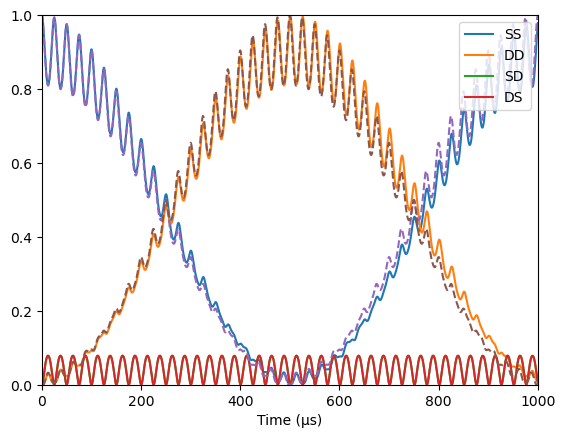

  4.140306 seconds (4.17 M allocations: 444.828 MiB, 17.09% gc time, 60.20% compilation time)


In [103]:
modecutoff!(mode, 15)
ρi = dm(ionstate(chamber, ["S", "S"])) ⊗ thermalstate(mode, 2)  # thermal state
h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e5)
tspan = collect(0:0.25:1000)
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ρi, h)

SS = expect(ionprojector(chamber, "S", "S"), sol)
DD = expect(ionprojector(chamber, "D", "D"), sol)
SD = expect(ionprojector(chamber, "S", "D"), sol)
DS = expect(ionprojector(chamber, "D", "S"), sol)

fig = plt.figure()
plt.plot(tout, SS, label="SS")
plt.plot(tout, DD, label="DD")
plt.plot(tout, SD, label="SD")
plt.plot(tout, DS, label="DS")
ex = analytical.molmersorensen2ion(tspan, 1e-6Ω1, 1e-6ν, 1e-6ν + 1e-6ϵ, η, 2)
plt.plot(tspan, ex[1], ls="--")
plt.plot(tspan, ex[2], ls="--")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (μs)");
plt.display(fig)

There is some discrepancy because of the Lamb-Dicke approximation made in the analytical solution.

Adding more ions/lasers/modes is done in the same way.

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim C:\Users\abdel\.julia\packages\IonSim\s9QSU\src\iontraps.jl:94


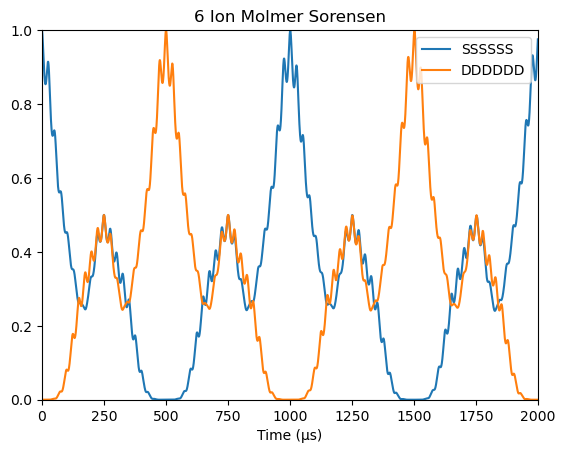

  2.025366 seconds (6.58 M allocations: 220.853 MiB, 1.84% gc time)


In [105]:
chain = LinearChain(
        ions=[ca, ca, ca, ca, ca, ca],
        comfrequencies=(x=3e6,y=3e6,z=1e6), 
        selectedmodes=(;z=[1])
    )
chamber = Chamber(iontrap=chain, B=4e-4, Bhat=(x̂ + ẑ)/√2, lasers=[laser1, laser2])
globalbeam!(laser1, chamber)  # set laser1 to shine equally on all ions
globalbeam!(laser2, chamber)  # set laser2 to shine equally on all ions
mode = zmodes(chamber)[1]
modecutoff!(mode, 5)
η = abs(lambdicke(mode, ca, laser1))
Ω2 = √(1e3 * ϵ) / η  
intensity_from_rabifrequency!(1, Ω2, 1, ("S", "D"), chamber)
intensity_from_rabifrequency!(2, Ω2, 1, ("S", "D"), chamber)
ψi = ionstate(chamber, repeat(["S"], 6)) ⊗ mode[0]

h = hamiltonian(chamber, timescale=1e-6, rwa_cutoff=5e5)
tspan = 0:0.25:2000
@time tout, sol = timeevolution.schroedinger_dynamic(tspan, ψi, h);

S = expect(ionprojector(chamber, repeat(["S"], 6)...), sol)
D = expect(ionprojector(chamber, repeat(["D"], 6)...), sol)

fig = plt.figure()
plt.plot(tout, S, label="SSSSSS")
plt.plot(tout, D, label="DDDDDD")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.title("6 Ion Molmer Sorensen")
plt.xlabel("Time (μs)");
plt.display(fig)

## IonSim.PhysicalConstants

Worth checking out